# Программная реализация алгоритма mDTW.

А.В. Гончаров. Выравнивание декартовых произведений упорядоченных множеств. 2019.

Ниже приведена программная реализация описанного в статье алгоритма. Статья доступна по адресу:

https://github.com/Intelligent-Systems-Phystech/PhDThesis/tree/master/Goncharov2019/MatrixDTW/doc

In [17]:
from skimage import io, color
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
import pylab

import numpy as np
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as PLT

import pickle
import time

from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
import matplotlib.pyplot as plt
import matplotlib

### Программная реализация

In [3]:
class classification_data():
    """
    This class helps to operate with datasets.
    """
    def __init__(self, data, coef = 4):
        """Data - pandas DataFrame with n**2 columns, which includes matrixes"""
        self.data_old = data[0]
        self.coef = coef
        self.old_dim = int(np.sqrt(self.data_old.shape[1]))
        self.new_dim = int(self.old_dim / self.coef)
        self.data_new = self.raw2raw(self.data_old)
        self.label = data[1]
        
    def convolve2d(self, image):
        output = np.zeros([int(image.shape[0]/self.coef), int(image.shape[1]/self.coef)]) 
        for x in range(output.shape[1]):    
            for y in range(output.shape[0]):
                output[y,x]=np.max(image[(self.coef*y):(self.coef*y+self.coef),(self.coef*x):(self.coef*x+self.coef)])
        return output

    def raw2raw(self, data):
        '''data - field with data, where n**2 columns. Label - is y for all objects from data'''
        n_objects = data.shape[0]
        data_new = pd.DataFrame(np.zeros((n_objects,self.new_dim**2)))
        for i in range(n_objects):
            data_new.iloc[i,:] = self.convolve2d(np.array(data.iloc[i,:]).reshape(self.old_dim,self.old_dim)).reshape(1,self.new_dim**2)
        return data_new

    def draw_mnist_convolve(self, img):
        img2 = convolve_mnist(img)
        fig = PLT.figure()

        ax1 = fig.add_subplot(121)
        ax1.imshow(img, cmap=plt.cm.gray)

        ax2 = fig.add_subplot(122)
        ax2.imshow(img2, cmap=plt.cm.gray)

        PLT.show()

    def draw_data(self, n_objects=1):
        if n_objects != 1:
            #list(np.random.randint(self.data_old.shape[0],size=(1,n_objects))[0,:]):
            print('TBD')
        else:
            for i in range(self.data_old.shape[0]):
                fig = plt.figure(figsize=(3,3))
                ax1 = fig.add_subplot(121)
                ax1.imshow(np.array(self.data_old.iloc[i,:]).reshape(self.old_dim,self.old_dim), cmap=plt.cm.gray)

                ax2 = fig.add_subplot(122)
                ax2.imshow(np.array(self.data_new.iloc[i,:]).reshape(self.new_dim,self.new_dim), cmap=plt.cm.gray)

                plt.show()

In [103]:
def generator(collection = 'mnist', n_objects = 50, class_number = 2):
    """
    Generates different types of Data.
    :param str collection: {'mnist','random','spectr'}
    :param int n_objects: how many objects for each class in Dataset
    :param int class_number: number of classes.
    Returns the dataset for processing: X and y.
    """
    if collection == 'mnist':
        try:
            data = pd.read_csv('train.csv')
            X = data[(data.label == 1) + (data.label == 0)].sample(n_objects*class_number)
            return (X.iloc[:,1:], pd.Series(X.label))
        except:
            print('No mnist data in the folder or sampling error')
            
    if collection == 'random':
        dim = 7
        data = np.zeros((n_objects*class_number,dim**2))
        labels = []
        for k in range(dim**2):
            labels.append('pixel'+str(k))
            
        for i in range(class_number):
            for j in range(n_objects):
                
                if i == 0:
                    row_index = np.random.randint(1,dim-1)
                    object_x = data[(i*n_objects + j),:].reshape(dim,dim)
                    object_x[row_index,:] += 1
                    if (np.random.randint(2)==1) and (row_index < (dim-2)):
                        object_x[(row_index + 1),:] += 1
                    data[(i*n_objects + j),:] = object_x.reshape(1,dim**2)
                
                if i == 1:
                    col_index = np.random.randint(1,dim-1)
                    object_x = data[(i*n_objects + j),:].reshape(dim,dim)
                    object_x[:,col_index] += 1
                    if (np.random.randint(2)==1) and (col_index < (dim-2)):
                        object_x[:,(col_index + 1)] += 1
                    data[(i*n_objects + j),:] = object_x.reshape(1,dim**2)
                    
        #data += np.random.random((n_objects*class_number,dim**2))/1.3
        data = pd.DataFrame(data,columns=labels)
        return (255*data, pd.Series([0]*n_objects + [1]*n_objects))
    
    if collection == 'spectr':
        FD = 250000#частота дискретизации, отсчётов в секунду
        N = 5000#длина входного массива, N/FD секунд 
        N_ = 2500#длина окна
        s = 35 #сдвиг
        F=250.0#циклическая частота входного сигнала
        w=(2.*pi*F/FD)#отсчёт круговой частоты 
        A=3.0#амплитуда сигнала
        B=0.5#порог ограничения
        #сгенерируем чистый синусоидальный сигнал с частотой F длиной N
        sin_sig_1 = array([A*sin(w*t) for t in range(N)]) + np.random.random(N)#график сигнала
        sin_sig_2 =array([A*sin(w*t) if abs(A*sin(w*t))<B else A*sin(w*t)*B/abs(A*sin(w*t)) for t in range(N)])*3 + np.random.random(N)
        sin_sig_3 = array([A*sin(w*t) if abs(A*sin(w*t))<B else 0 for t in range(N)])+ np.random.random(N)/20

        matplotlib.rcParams.update({'font.size': 22,'font.family':'Times New Roman'})
        plt.plot(arange(N)/float(FD), sin_sig_1, 'r')
        plt.xlabel('Время, сек.')
        plt.ylabel('Амплитуда  сигнала')
        #plt.title('Входной синусоидальный сигнала')
        plt.grid(True)
        plt.show()
        
        plt.plot(arange(N)/float(FD), sin_sig_2, 'r')
        plt.xlabel('Время, сек.')
        plt.ylabel('Амплитуда  сигнала')
        #plt.title('Входной синусоидальный сигнала')
        plt.grid(True)
        plt.show()
        
        plt.plot(arange(N)/float(FD), sin_sig_3, 'r')
        plt.xlabel('Время, сек.')
        plt.ylabel('Амплитуда  сигнала')
        #plt.title('Входной синусоидальный сигнала')
        plt.grid(True)
        plt.show()

        spectr_1 = []
        for i in range(int(N/s/2)):
            sin_sig_ = sin_sig_1[(i*s) : (i*s+N_)]
            spectr_1.append(rfft(sin_sig_ ))
        spectr_2 = []
        for i in range(int(N/s/2)):
            sin_sig_ = sin_sig_2[(i*s) : (i*s+N_)]
            spectr_2.append(rfft(sin_sig_ ))
        spectr_3 = []
        for i in range(int(N/s/2)):
            sin_sig_ = sin_sig_3[(i*s) : (i*s+N_)]
            spectr_3.append(rfft(sin_sig_ ))
        
        aaa_1 = np.concatenate([np.matrix(np_abs(x)/N_).T for x in spectr_1], axis=1)
        aaa_2 = np.concatenate([np.matrix(np_abs(x)/N_).T for x in spectr_2], axis=1)
        aaa_3 = np.concatenate([np.matrix(np_abs(x)/N_).T for x in spectr_3], axis=1)
        
        plt.figure()
        plt.imshow(aaa_1[:20,:20])
        plt.figure()        
        plt.imshow(aaa_2[:20,:20])        
        plt.figure()        
        plt.imshow(aaa_3[:20,:20])
        
        aaa_1_ = []
        for i in range(n_objects):
            aaa_1_.append(aaa_1[:20,(i*4):(i*4+20)])
        
    
        aaa_2_ = []
        for i in range(n_objects):
            aaa_2_.append(aaa_2[:20,(i*4):(i*4+20)])
        
    
        aaa_3_ = []
        for i in range(n_objects):
            aaa_3_.append(50*(aaa_3[:20,(i*4):(i*4+20)]))
        
        data = np.zeros((n_objects*3,20**2))
        for i in range(n_objects):
            data[i,:] = aaa_1_[i].reshape(1,20**2)
        for i in range(n_objects):
            data[(n_objects + i),:] = aaa_2_[i].reshape(1,20**2)
        for i in range(n_objects):
            data[(2*n_objects + i),:] = aaa_3_[i].reshape(1,20**2)
        
        return (255*pd.DataFrame(data), pd.Series([0]*n_objects + [1]*n_objects + [2]*n_objects))
    

        #spectr_sin = rfft(sin_sig )#вычисляем дискретное действительное rfft  преобразование Фурье
        #plt.plot(rfftfreq(N_, 1./FD), np_abs(spectr[0])/N_) #график спектра
        #plt.xlabel('Частота, Гц')
        #plt.ylabel('Амплитуда  сигнала')
        #plt.title('Спектр синусоидального сигнала')
        #plt.grid(True)
        #plt.show()

In [87]:
def local_cost(A,B,pi_local):
    """
    Calculates the cost of the path.
    """
    cost = 0
    for pair in pi_local:
        cost += (A[(pair[0][0]),(pair[0][1])] - B[(pair[1][0]),(pair[1][1])])**2
    return cost

def min_index(i,j,k,l,cost_matrix):
    """
    Returns the index of minimum index.
    """
    idx = np.argmin([cost_matrix[i,j,k,l],
                      cost_matrix[i+1,j,k+1,l],
                      cost_matrix[i,j+1,k,l+1],
                      cost_matrix[i,j+1,k+1,l+1],
                      cost_matrix[i+1,j,k+1,l+1],
                      cost_matrix[i+1,j+1,k,l+1],
                      cost_matrix[i+1,j+1,k+1,l]])
    return idx, [[i-1,j-1,k-1,l-1],
                      [i,j-1,k,l-1],
                      [i-1,j,k-1,l],
                      [i-1,j,k,l],
                      [i,j-1,k,l],
                      [i,j,k-1,l],
                      [i,j,k,l-1]][idx]

def DTW_matrix(A,B, print_results = False):
    """
    Calculate the distance.
    :param matrix A: N*N numpy matrix
    :param matrix B: N*N numpy matrix
    :param boolean: Identificator for printing warping results.
    Returns the cost, cost matrix, warping path.
    """
    length = A.shape[0]

    pi_path = [[[[[] for k in range(length)]for z in range(length)]for x in range(length)] for y in range(length)]
    pi_path[0][0][0][0] = [[[0,0],[0,0]]]
    
    cost_matrix = np.zeros((length + 1, length + 1, length + 1, length + 1)) + np.inf
    cost_matrix[0,0,0,0] = 0
    cost_matrix[1,1,1,1] = cost_matrix[0,0,0,0] + (A[1,1] - B[1,1])**2

    previous_index_type = np.zeros((length , length , length , length ))
    previous_index = [[[[[] for k in range(length)]for z in range(length)]for x in range(length)] for y in range(length)]
    
    for i in range(0,length):
        for j in range(0,length):
            for k in range(max((i-5),0),min((i+5),length)):
                for l in range(max((j-5),0),min((j+5),length)):
                    
                    idx, [i_,j_,k_,l_] = min_index(i,j,k,l,cost_matrix)                      
                    
                    previous_index_type[i,j,k,l] = idx
                    previous_index[i][j][k][l] = [i_,j_,k_,l_]
                    
                    if (i,j,k,l) != (0,0,0,0): 
                        
                        if idx == 0:
                            
                            pi_path[i][j][k][l] = pi_path[i-1][j-1][k-1][l-1].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][0]==(i-1))and(x[1][0]==(k-1)))].copy()
                            pi_2 = [x for x in pi_path[i][j][k][l] if ((x[0][1]==(j-1))and(x[1][1]==(l-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][0] = i
                                pair[1][0] = k
                                
                            pi_2_ = []
                            for pair in pi_2:
                                pi_2_.append([list(x.copy()) for x in pair])
                            for pair in pi_2_:
                                pair[0][1] = j
                                pair[1][1] = l
                            
                            pi_path[i][j][k][l].extend(pi_1_)
                            pi_path[i][j][k][l].extend(pi_2_)
                            pi_path[i][j][k][l].append([[i,j],[k,l]])
                                                    
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i,j,k,l] + local_cost(A,B,pi_1_) + local_cost(A,B,pi_2_) + (A[i,j] - B[k,l])**2

                        if idx == 1:

                            pi_path[i][j][k][l] = pi_path[i][j-1][k][l-1].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][1]==(j-1))and(x[1][1]==(l-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][1] = j
                                pair[1][1] = l
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i+1,j,k+1,l] + local_cost(A,B,pi_1_)

                        if idx == 2:

                            pi_path[i][j][k][l] = pi_path[i-1][j][k-1][l].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][0]==(i-1))and(x[1][0]==(k-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][0] = i
                                pair[1][0] = k
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i,j+1,k,l+1] + local_cost(A,B,pi_1_) 

                        if idx == 3:
                            
                            pi_path[i][j][k][l] = pi_path[i-1][j][k][l].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][0]==(i-1))and(x[1][0]==(k)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][0] = i
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i,j+1,k+1,l+1] + local_cost(A,B,pi_1_) 

                        if idx == 4:
                            
                            pi_path[i][j][k][l] = pi_path[i][j-1][k][l].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][1]==(j-1))and(x[1][1]==(l)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][1] = j
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i+1,j,k+1,l+1] + local_cost(A,B,pi_1_) 

                        if idx == 5:
                            
                            pi_path[i][j][k][l] = pi_path[i][j][k-1][l].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][0]==(i))and(x[1][0]==(k-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[1][0] = k
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i+1,j+1,k,l+1] + local_cost(A,B,pi_1_) 
                            
                        if idx == 6:
                            
                            pi_path[i][j][k][l] = pi_path[i][j][k][l-1].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][1]==j)and(x[1][1]==(l-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[1][1] = l
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i+1,j+1,k+1,l] + local_cost(A,B,pi_1_)
                        
                        if print_results == True:
                            print(i,j,k,l)
                            print(idx)
                            print(pi_path[i][j][k][l])
                            print(cost_matrix[i+1,j+1,k+1,l+1])
                            print(local_cost(A,B,pi_1_))
                
    return np.sqrt(cost_matrix[length,length,length,length]), cost_matrix, pi_path, previous_index                        

In [117]:
def calculate_distance(x_1, x_2, draw = False):
    """
    This function helps to use the algorithm ans to see results.
    """
    len_1 = int(np.sqrt(len(x_1)))
    len_2 = int(np.sqrt(len(x_2)))
    x_1 = np.array(x_1).reshape(len_1,len_1)
    x_2 = np.array(x_2).reshape(len_2,len_2)
    Cost, cost_matrix, path, previous_index = DTW_matrix(x_1,x_2)
    if draw == True:
        matplotlib.rcParams.update({'font.size': 44,'font.family':'Times New Roman'})
        fig = plt.figure(figsize=(30,10))
        ax1 = fig.add_subplot(121)
        
        for el in path[len_1-1][len_1-1][len_2-1][len_2-1]:
            if x_1[el[0][0],el[0][1]] >= 196:
                ax1.plot([el[0][0],el[1][0]+len_1+1],[el[0][1],el[1][1]+1],linewidth=4.0)
        ax1.imshow(
                np.concatenate((
                    np.concatenate((np.array(x_1).reshape(len_1,len_1).T,np.matrix([255]*len_1))), 
                    np.matrix([255]*(len_1+1)).T,
                    np.concatenate((np.matrix([255]*len_1),np.array(x_2).reshape(len_2,len_2).T))
                ),axis = 1), cmap=plt.cm.gray)
        plt.title("Distance = "+str(int(Cost)))
        plt.ylim(len_1+1)
        plt.show()
        
    return Cost, cost_matrix, path, previous_index

### Примериспользования программной реализации

In [107]:
X = classification_data(generator(collection = 'mnist', n_objects = 10), coef=2)
#X.draw_data()

/Users/aleksej/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


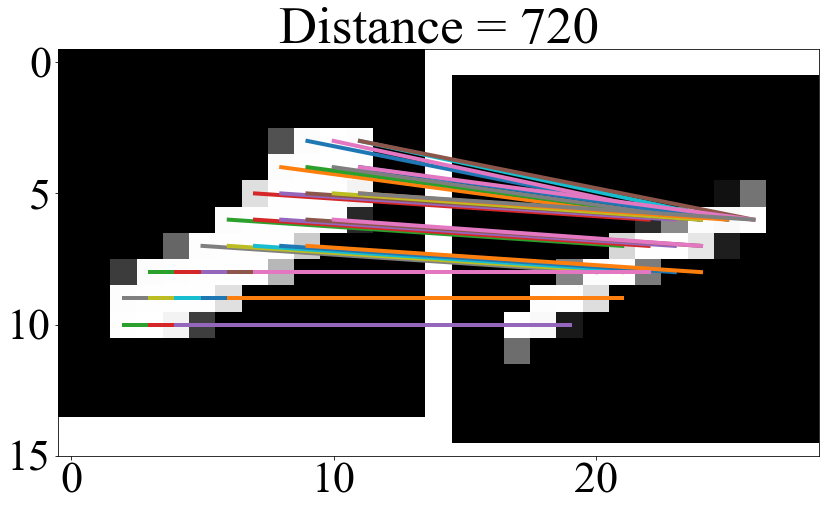

In [118]:
Cost, cost_matrix, path, previous_index = calculate_distance(X.data_new.iloc[5,:],X.data_new.iloc[8,:],draw=True)